In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/DL_final_df.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The dataframe is already loaded in the previous cell.
# df = pd.read_csv('/content/drive/MyDrive/DL_MERGE_BOOKS_df.csv')

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Desired sample sizes based on % targets
target_counts = {
    1: 350000,
    2: 470000,
    3: 620000,
    4: 800000,
    5: 980000
}

# Apply sampling
sampled = []

for rating, count in target_counts.items():
    group = df[df['rating'] == rating]
    sampled.append(group.iloc[:count])  # get top N

DL_final_df = pd.concat(sampled).reset_index(drop=True)

# Check result
print(DL_final_df['rating'].value_counts(normalize=True) * 100)

rating
5    30.434783
4    24.844720
3    19.254658
2    14.596273
1    10.869565
Name: proportion, dtype: float64


In [ ]:
!pip install tensorflow

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,659,461 (10.15 MB)

 Trainable params: 2,659,461 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
18113/18113 ━━━━━━━━━━━━━━━━━━━━ 365s 20ms/step - accuracy: 0.5357 - loss: 1.0671 - val_accuracy: 0.5946 - val_loss: 0.9279
Epoch 2/20
18113/18113 ━━━━━━━━━━━━━━━━━━━━ 381s 20ms/step - accuracy: 0.6028 - loss: 0.9155 - val_accuracy: 0.6018 - val_loss: 0.9149
Epoch 3/20
18113/18113 ━━━━━━━━━━━━━━━━━━━━ 386s 20ms/step - accuracy: 0.6216 - loss: 0.8719 - val_accuracy: 0.6052 - val_loss: 0.9041
Epoch 4/20
18113/18113 ━━━━━━━━━━━━━━━━━━━━ 383s 20ms/step - accuracy: 0.6384 - loss: 0.8376 - val_accuracy: 0.6046 - val_loss: 0.9139
Epoch 5/20
18113/18113 ━━━━━━━━━━━━━━━━━━━━ 371s 20ms/step - accuracy: 0.6534 - loss: 0.8068 - val_accuracy: 0.6040 - val_loss: 0.9177
Epoch 6/20
18113/18113 ━━━━━━━━━━━━━━━━━━━━ 348s 19ms/step - accuracy: 0.6669 - loss: 0.7785 - val_accuracy: 0.6027 - val_loss: 0.9346
20125/20125 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step
Accuracy: 0.6052
Classification Report:

              precision    recall  f1-score   support

           1       0.60      0.61      0.61    

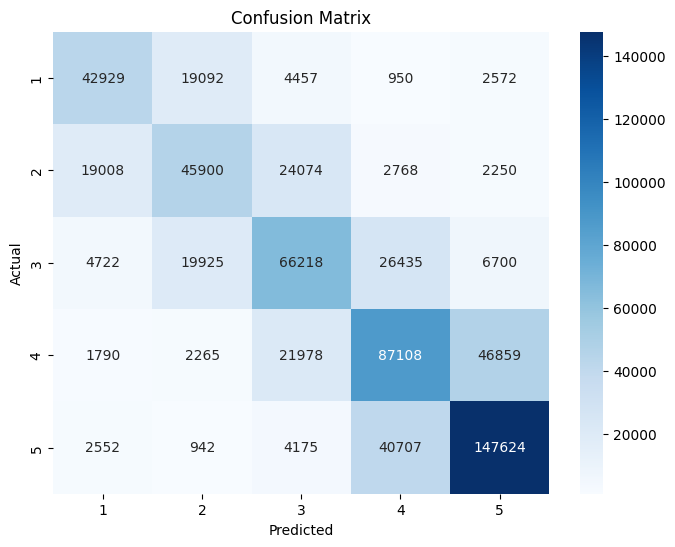

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------
# Prepare data
# ----------------------
# Convert 'review' column to string type to handle potential non-string values
df['review'] = df['review'].astype(str)

X = df['review']
y = df['rating']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical,
    test_size=0.2,
    stratify=y_categorical,
    random_state=42
)

# Tokenization and padding
max_words = 20000
max_len = 150

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# ----------------------
# Build BiLSTM Model
# ----------------------
embedding_dim = 128
lstm_units = 64
num_classes = y_categorical.shape[1]

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Build model to show correct summary
model.build(input_shape=(None, max_len))
model.summary()

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',   # you can also use 'val_accuracy'
    patience=3,           # number of epochs with no improvement before stopping
    restore_best_weights=True # restores weights from the epoch with best val_loss
)


# ----------------------
# Train Model
# ----------------------
history = model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,callbacks=[early_stop]
)

# ----------------------
# Evaluate Model
# ----------------------
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1-Score
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in le.classes_]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
n = 5
for rating in range(1, 6):
    filtered_reviews = df[df['rating'] == rating]['review'].dropna()
    sample_reviews = filtered_reviews.sample(n=min(n, len(filtered_reviews)), random_state=rating)

    # Print results
    print(f"\nShowing {min(n, len(filtered_reviews))} sample review(s) for Rating {rating}:\n")
    for i, review in enumerate(sample_reviews, 1):
        print(f"{i}. {review.strip()}\n")


Showing 5 sample review(s) for Rating 1:

1. i got this arc from the publisher at new york comic con im not sure if im supposed to acknowledge that or not so im putting it here anyways this doesnt make my views any different thank you what i liked nothing cries what i didnt like i wasnt a big fan of the writing in spindle fire i usually love elegant flowery writing but i felt like this was more telling you than showing you that and the tense is what really bothered me most spindle fire takes place in i think and its written in present tense the author can do what she wants with the tense thats cool but it kept taking me away from what was happening i kept questioning why it was written like it was happening right now if it took place in the past i think that might be the biggest reason why i didnt like this book at all im not sure what i was really expecting from spindle fire and im really not sure why i finished it either from the very first page it was slow and boring i hoped that e

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count ratings
rating_counts = df['rating'].value_counts().sort_index()

# Pie chart
plt.pie(rating_counts,
        labels=rating_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("viridis", len(rating_counts)))

plt.title("Ratings Distribution (Pie Chart)")
plt.show()

In [ ]:
model.save('Model_DL.h5')

In [ ]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# 3. Save Label Encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [ ]:
!pip install torchtext

In [ ]:
!pip uninstall torch torchtext -y
!pip install torch==2.3.0+cu121 torchtext==0.18.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchtext.vocab import Vocab, GloVe
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

In [ ]:
# df: your DataFrame with ['text','label']
# Filter to include only ratings 1-5
DL_final_df = DL_final_df[DL_final_df['rating'].isin([1, 2, 3, 4, 5])]

DL_final_df['rating'] = DL_final_df['rating'].astype(int) - 1  # convert 1-5 -> 0-4

# Fill potential NaN values in the 'review' column with empty strings
DL_final_df['review'] = DL_final_df['review'].fillna('')

# Train/Validation/Test split
train_df, temp_df = train_test_split(DL_final_df, test_size=0.2, stratify=DL_final_df['rating'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['rating'], random_state=42)

# Tokenizer
tokenizer = get_tokenizer('basic_english')

# Build vocabulary from training data
counter = Counter()
for text in train_df['review']:
    counter.update(tokenizer(text))

# Updated way to build Vocab in torchtext
from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator(counter.keys(), specials=['<pad>', '<unk>'])

pad_idx = vocab['<pad>']
vocab.set_default_index(vocab['<unk>']) # Set default index for unknown tokens


# Load GloVe embeddings
glove = GloVe(name='6B', dim=100)

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, df, vocab, tokenizer, max_len=200):
        self.texts = df['review'].tolist()  # Changed from 'text' to 'review'
        self.labels = df['rating'].tolist()  # Changed from 'label' to 'rating'
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts[idx])[:self.max_len]
        ids = [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in tokens]
        return torch.tensor(ids), torch.tensor(self.labels[idx])

def collate_batch(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=pad_idx)
    labels = torch.tensor(labels)
    return texts, labels

batch_size = 64
train_loader = DataLoader(ReviewDataset(train_df, vocab, tokenizer), batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(ReviewDataset(val_df, vocab, tokenizer), batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(ReviewDataset(test_df, vocab, tokenizer), batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [ ]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab, embed_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3, pad_idx=0):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_dim, padding_idx=pad_idx)

        # Initialize embedding with GloVe
        embedding_matrix = torch.zeros(len(vocab), embed_dim)
        # Use get_itos() to get the list of tokens
        for i, token in enumerate(vocab.get_itos()):
            if token in glove.stoi:
                embedding_matrix[i] = glove[token]
            else:
                embedding_matrix[i] = torch.randn(embed_dim)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = True  # fine-tune embeddings

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(self.dropout(hidden))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5


In [ ]:
num_epochs = 20
patience = 3  # stop if no improvement after 3 epochs
best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device, dtype=torch.long), labels.to(device)  # Cast texts to Long
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device, dtype=torch.long), labels.to(device)  # Cast texts to Long
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # ---- Early Stopping ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")  # save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    return acc, precision, recall, f1, cm


In [ ]:
train_acc, train_prec, train_rec, train_f1, train_cm = evaluate_model(model, train_loader, device)
val_acc, val_prec, val_rec, val_f1, val_cm = evaluate_model(model, val_loader, device)
test_acc, test_prec, test_rec, test_f1, test_cm = evaluate_model(model, test_loader, device)

print("=== TRAIN RESULTS ===")
print(f"Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f1:.4f}")
print("Confusion Matrix:\n", train_cm)

print("\n=== VALIDATION RESULTS ===")
print(f"Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")
print("Confusion Matrix:\n", val_cm)

print("\n=== TEST RESULTS ===")
print(f"Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}")
print("Confusion Matrix:\n", test_cm)